### Data Translation

In [ ]:
!pip install deep_translator

In [ ]:
import csv
import time
from deep_translator import GoogleTranslator
from requests.exceptions import ReadTimeout

def split_text(text, max_length=4500):
    """Memecah teks menjadi bagian-bagian yang lebih kecil."""
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0
    for word in words:
        if current_length + len(word) + 1 > max_length:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_length = len(word)
        else:
            current_chunk.append(word)
            current_length += len(word) + 1
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    return chunks

from deep_translator.exceptions import TranslationNotFound

def translate_with_retry(translator, text, max_retries=3, delay=1):
    for attempt in range(max_retries):
        try:
            if len(text) > 4500:  # Adjust chunk size for stability
                chunks = split_text(text, max_length=2000)  # Smaller chunks
                translated_chunks = [translator.translate(chunk) for chunk in chunks]
                return ' '.join(translated_chunks)
            else:
                return translator.translate(text)
        except (ReadTimeout, TranslationNotFound) as e:
            if attempt < max_retries - 1:
                time.sleep(delay)
            else:
                print(f"Failed to translate text: {text[:100]}...")  # Debugging step
                print(f"Error: {e}")
                return "[Translation Failed]"

def get_last_translated_row(output_file):
    """Mendapatkan jumlah baris terakhir yang telah diterjemahkan."""
    try:
        with open(output_file, 'r', encoding='utf-8') as outfile:
            reader = csv.reader(outfile)
            lines = list(reader)
            return len(lines)  # Mengembalikan jumlah baris yang sudah ada
    except FileNotFoundError:
        return 0

def translate_csv(input_file, output_file, columns_to_translate, source_lang='auto', target_lang='id', batch_size=10):
    translator = GoogleTranslator(source=source_lang, target=target_lang)

    last_translated_row = get_last_translated_row(output_file)

    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'a', newline='', encoding='utf-8') as outfile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)

        if last_translated_row == 0:
            writer.writeheader()

        for _ in range(last_translated_row):
            next(reader)

        batch = []
        for row in reader:
            batch.append(row)
            if len(batch) >= batch_size:
                process_batch(batch, translator, writer, columns_to_translate)
                batch = []
                time.sleep(1)  # Delay between batches

        if batch:
            process_batch(batch, translator, writer, columns_to_translate)

def process_batch(batch, translator, writer, columns_to_translate):
    for row in batch:
        for column in columns_to_translate:
            if column in row:
                row[column] = translate_with_retry(translator, row[column])
        writer.writerow(row)

# Penggunaan
columns_to_translate = ['full_text']
translate_csv('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/filtered_sampled.csv', '/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/test_indo.csv', columns_to_translate, source_lang='en', target_lang='id')

### Data Augmentation

#### Paraphrase Essay

In [ ]:
!pip install ollama
!pip install langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4


In [ ]:
import random
import string
import pandas as pd
import os
from langchain.llms import Ollama

# Inisialisasi Ollama dengan model Llama 3
llm = Ollama(model="llama3", keep_alive="3h", temperature=0.7)

# Fungsi untuk menghasilkan ID acak
def generate_id():
    prefix = ''.join(random.choices(string.digits, k=3))
    suffix = ''.join(random.choices(string.ascii_lowercase + string.digits, k=3))
    return f"{prefix}d{suffix}"

# Fungsi untuk memparafrasekan esai dan menghasilkan versi baru
def paraphrase_essay(full_text):
    try:
        prompt = f"""
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Anda adalah seseorang yang memiliki kemampuan berbahasa Indonesia yang baik.
Parafrasekan esai berikut dalam bahasa Indonesia dengan panjang teks sebanyak 3000 - 5000 karakter
dan pertahankan makna aslinya:

**Esai Asli:**

"{full_text}"

<|eot_id|><|start_header_id|>assistant<|end_header_id|>

**Esai Parafrase:**
"""
        response = llm(prompt)

        if not response:
            print("Tidak ada respons dari model.")
            return "Parafrase gagal."
        else:
            cleaned_response = response.strip()
            if "**Esai Parafrase:**" in cleaned_response:
                cleaned_response = cleaned_response.split("**Esai Parafrase:**")[-1].strip()
            return cleaned_response
    except Exception as e:
        print(f"Terjadi kesalahan saat memparafrase: {e}")
        return "Parafrase gagal."

# Fungsi untuk memparafrasekan esai dan langsung menulis hasil ke file CSV
def paraphrase_essays_from_csv(input_csv_path, output_csv_path, status_file):
    # Membaca data dari CSV
    df = pd.read_csv(input_csv_path)

    # Cek ID terakhir yang berhasil diproses
    last_processed_id = None
    if os.path.exists(status_file):
        with open(status_file, 'r') as file:
            last_processed_id = file.read().strip()

    essays_to_paraphrase = df[df['score'] == 5]

    for index, row in essays_to_paraphrase.iterrows():
        original_text = row['full_text']
        essay_id = row['essay_id'] if 'essay_id' in row else generate_id()

        # Lewati esai yang sudah diproses
        if last_processed_id and essay_id <= last_processed_id:
            continue

        for i in range(2):  # Sesuaikan jumlah iterasi jika perlu
            print(f"Memparafrasekan esai {essay_id}, versi {i + 1}...")
            paraphrased_text = paraphrase_essay(original_text)

            # Append hasil parafrase langsung ke CSV
            df_paraphrased = pd.DataFrame({
                'essay_id': [generate_id()],
                'full_text': [paraphrased_text],
                'score': [row['score']]
            })
            df_paraphrased.to_csv(output_csv_path, mode='a', index=False, header=not os.path.exists(output_csv_path))

        # Simpan ID terakhir yang berhasil diproses
        with open(status_file, 'w') as file:
            file.write(essay_id)

    print(f"Parafrase esai dengan skor 5 telah diperbarui dan disimpan ke {output_csv_path}")

# Contoh penggunaan
input_csv = '/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/aug_train_indo.csv'
output_csv = '/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/aug_train_indo2.csv'
status_file = '/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/processing_status.txt'

paraphrase_essays_from_csv(input_csv, output_csv, status_file)

<ipython-input-3-1d483968d0dc>:8: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3", keep_alive="3h", temperature=0.7)


Memparafrasekan esai fb7c7a9, versi 1...


<ipython-input-3-1d483968d0dc>:34: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(prompt)


Memparafrasekan esai fb7c7a9, versi 2...
Memparafrasekan esai fb97d68, versi 1...
Memparafrasekan esai fb97d68, versi 2...
Memparafrasekan esai fbb5a77, versi 1...
Memparafrasekan esai fbb5a77, versi 2...
Memparafrasekan esai fbc2ba4, versi 1...
Memparafrasekan esai fbc2ba4, versi 2...
Memparafrasekan esai fbd60ab, versi 1...
Memparafrasekan esai fbd60ab, versi 2...
Memparafrasekan esai fbde6e5, versi 1...
Memparafrasekan esai fbde6e5, versi 2...
Memparafrasekan esai fbf6eb8, versi 1...
Memparafrasekan esai fbf6eb8, versi 2...
Memparafrasekan esai fc2b46e, versi 1...
Memparafrasekan esai fc2b46e, versi 2...
Memparafrasekan esai fc68dd9, versi 1...
Memparafrasekan esai fc68dd9, versi 2...
Memparafrasekan esai fc7b015, versi 1...
Memparafrasekan esai fc7b015, versi 2...
Memparafrasekan esai fcbcc24, versi 1...
Memparafrasekan esai fcbcc24, versi 2...
Memparafrasekan esai fce26a2, versi 1...
Memparafrasekan esai fce26a2, versi 2...
Memparafrasekan esai fcf0ded, versi 1...
Memparafrasekan 

#### Merge Data

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/aug_train_indo2.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/indo_data_filtered.csv')

combined_df = pd.concat([df1, df2], ignore_index=True)

combined_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/augmented_concat_dataset_clean.csv', index=False)

### Undersampling

In [ ]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from collections import Counter

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/augmented_concat_dataset_clean.csv')  # Ganti dengan nama file Anda

X = df[['lower_full_text']]
y = df['score']

# Periksa distribusi awal
initial_distribution = Counter(y)
print("Distribusi awal:", initial_distribution)

# Pisahkan data untuk label 2, 3, dan 4 (kelas yang akan di-undersample)
df_label_2_3_4 = df[df['score'].isin([2, 3, 4])]
df_label_2_3_4_y = df_label_2_3_4['score']

# Hitung distribusi normal untuk label 2, 3, dan 4
mean = df_label_2_3_4_y.mean()
std_dev = df_label_2_3_4_y.std()

# Tentukan jumlah sample berdasarkan distribusi normal untuk label 2, 3, dan 4
num_samples = int(len(df_label_2_3_4) * 0.7)  # Misalnya 70% dari data

# Hasil sampling berdasarkan distribusi normal
samples = np.random.normal(loc=mean, scale=std_dev, size=num_samples)

# Batas untuk sampling normal
samples = np.clip(samples, 2, 4)  # Pastikan nilai tetap berada antara 2 dan 4

# Ambil sample berdasarkan distribusi normal
sampled_labels = [round(x) for x in samples]

# Pilih data dari label 2, 3, dan 4 berdasarkan hasil sampling
sampled_indices = df_label_2_3_4.loc[np.random.choice(df_label_2_3_4.index, num_samples)].index
df_resampled_2_3_4 = df_label_2_3_4.loc[sampled_indices]

# Gabungkan kembali dengan data label lainnya
df_label_others = df[~df['score'].isin([2, 3, 4])]
df_resampled = pd.concat([df_label_others, df_resampled_2_3_4])

# Periksa distribusi setelah undersampling
final_distribution = Counter(df_resampled['score'])
print("Distribusi setelah undersampling:", final_distribution)

# Simpan hasil resampling ke CSV
# df_resampled.to_csv('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/undersampled_data5.csv', index=False)
# print("Hasil undersampling disimpan sebagai 'undersampled_normal_distribution_labels_2_3.csv'")

Distribusi awal: Counter({3: 6280, 2: 4723, 4: 3926, 5: 2894, 6: 2575, 1: 2280})
Distribusi setelah undersampling: Counter({3: 4445, 2: 3270, 5: 2894, 4: 2735, 6: 2575, 1: 2280})


### Data Preprocessing and Cleaning

In [ ]:
import string

def cleaningText(text):
    text = text.lower()  # lowercase text
    text = text.replace('\n', ' ')  # replace new line into space
    text = text.replace('-', ' ')  # replace hyphen with space
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove all punctuations except hyphen
    text = text.strip(' ')  # remove space from both left and right text
    return ' '.join(text.split())  # ensure no extra spaces
    return text

In [ ]:
df['lower_full_text'] = df['full_text'].apply(cleaningText)

In [ ]:
df.head()

,essay_id,full_text,score,lower_full_text
0,000d118,Banyak orang punya mobil di tempat tinggal mer...,3,banyak orang punya mobil di tempat tinggal mer...
1,000fe60,Saya seorang ilmuwan di NASA yang sedang memba...,3,saya seorang ilmuwan di nasa yang sedang memba...
2,001ab80,Orang-orang selalu berharap memiliki teknologi...,4,orang orang selalu berharap memiliki teknologi...
3,001bdc0,"Kita semua pernah mendengar tentang Venus, pla...",4,kita semua pernah mendengar tentang venus plan...
4,002ba53,"Yang terhormat, Senator Negara Bagian\n\nIni a...",3,yang terhormat senator negara bagian ini adala...


### Baseline Training

In [ ]:
!pip install sentence-transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from torch import nn
from sklearn.model_selection import KFold
import pandas as pd
from datasets import Dataset
from sklearn.metrics import cohen_kappa_score
from sentence_transformers import SentenceTransformer
import numpy as np

MODEL_NAME = 'indolem/indobert-base-uncased'
SENTENCE_EMBEDDING = 'denaya/indoSBERT-large'
FOLDS = [0,1,2,3]
MAX_LENGTH = 512
BATCH_SIZE = 8
EPOCHS = 5
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/concat_undersample_baseline_saved_model6'

#### Tokenization IndoBERT

In [ ]:
# Tokenization with IndoBERT
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

csv_path = '/content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/undersampled_data5.csv'
df = pd.read_csv(csv_path)

texts = df['lower_full_text'].tolist()
df['label'] = df['score'] - 1
labels = df['label'].tolist()

def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True, max_length=MAX_LENGTH)

# Convert the pandas dataframe to Huggingface Dataset
dataset = Dataset.from_pandas(df)

# Apply tokenization
tokenized_datasets = dataset.map(lambda e: tokenize_function(e['lower_full_text']), batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/18199 [00:00<?, ? examples/s]

In [ ]:
# Evaluation metric QWK
def compute_qwk(p):
    preds = np.argmax(p.predictions, axis=1)
    qwk_score = cohen_kappa_score(p.label_ids, preds, weights='quadratic')
    return {"qwk": qwk_score}

In [ ]:
# Extract embedding for each essay using IndoSBERT
from sentence_transformers import SentenceTransformer

sentence_transformer = SentenceTransformer(SENTENCE_EMBEDDING)

def add_sentence_embeddings(examples):
    embeddings = sentence_transformer.encode(examples['lower_full_text'], convert_to_tensor=True)
    return {'sentence_embedding': embeddings.tolist()}

tokenized_datasets = tokenized_datasets.map(add_sentence_embeddings, batched=True)

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.23k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

Map:   0%|          | 0/18199 [00:00<?, ? examples/s]

In [ ]:
# Adding IndoSBERT embedding size to the IndoBERT configuration
class CombinedModelForSequenceClassification(AutoModelForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)

        if hasattr(config, 'embedding_size'):
            embedding_size = config.embedding_size
        else:
            raise ValueError("Config harus memiliki atribut 'embedding_size'.")

        self.hidden_size = config.hidden_size
        self.batch_norm = nn.BatchNorm1d(self.hidden_size + self.embedding_size)
        self.classifier = nn.Linear(self.hidden_size + embedding_size, config.num_labels)
        nn.init.xavier_uniform_(self.classifier.weight)
        if self.classifier.bias is not None:
            nn.init.zeros_(self.classifier.bias)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None, sentence_embedding=None):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
            return_dict=True
        )

        pooler_output = outputs.pooler_output  # Bentuk: (batch_size, hidden_size)

        if sentence_embedding is None:
            raise ValueError("sentence_embedding harus disediakan saat memanggil forward.")
        if pooler_output.size(0) != sentence_embedding.size(0):
            raise ValueError("Jumlah batch pada pooler_output dan sentence_embedding harus sama.")

        combined_embeddings = torch.cat((pooler_output, sentence_embedding), dim=-1)  # Bentuk: (batch_size, hidden_size + embedding_size)
        combined_embeddings = self.batch_norm(combined_embeddings)
        combined_embeddings = self.dropout(combined_embeddings)
        logits = self.classifier(combined_embeddings)  # Bentuk: (batch_size, num_labels)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else logits

In [ ]:
# Training
from transformers import AutoConfig

train_test_split = tokenized_datasets.train_test_split(test_size=0.25)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

embedding_size = sentence_transformer.get_sentence_embedding_dimension()
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=6)
config.embedding_size = embedding_size  # Tambahkan embedding_size ke config

baseline_model = CombinedModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
)

baseline_training_args = TrainingArguments(
    output_dir='./baseline_results',
    num_train_epochs=3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./baseline_logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='qwk',
    save_total_limit=1,
    learning_rate=5e-5
)

baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_qwk
)

print("Starting baseline training...")
baseline_trainer.train()

baseline_eval_results = baseline_trainer.evaluate()
print(f"Baseline model results: {baseline_eval_results}")

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-c2fa96db1a8c>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting baseline training...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Qwk
1,0.851500,0.927512,0.890320
2,0.629300,0.751969,0.916564
3,0.407500,0.831046,0.930657


Baseline model results: {'eval_loss': 0.8310455679893494, 'eval_qwk': 0.9306574639983228, 'eval_runtime': 137.9808, 'eval_samples_per_second': 32.976, 'eval_steps_per_second': 4.124, 'epoch': 3.0}


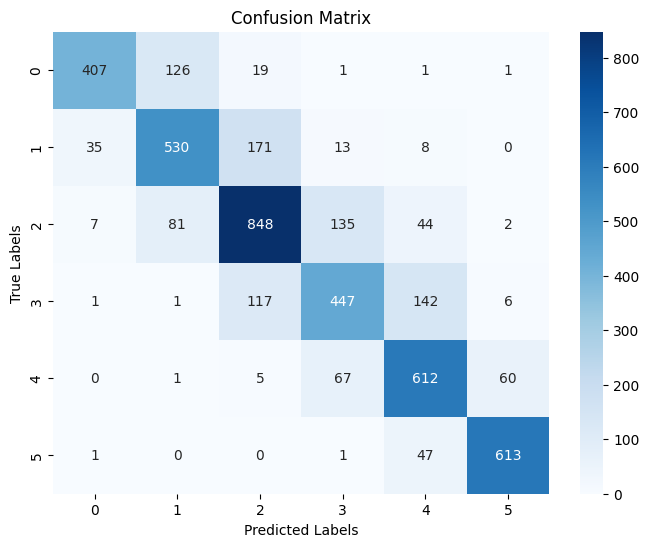

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions and true labels for evaluation dataset
predictions, labels, _ = baseline_trainer.predict(eval_dataset)

# Get the predicted class by taking the argmax of the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(labels, predicted_labels)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the trained baseline model
print(f"Saving the baseline model to {SAVE_DIR}...")
baseline_model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print(f"Baseline model saved successfully to {SAVE_DIR}.")

Saving the baseline model to /content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/concat_undersample_baseline_saved_model5...
Baseline model saved successfully to /content/drive/MyDrive/Colab Notebooks/Tugas Akhir_Nathania Elirica_5027211057/concat_undersample_baseline_saved_model5.


### Cross Validation

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Set up KFold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3 fold cross-validation
fold = 0
all_eval_results = []

# Perform cross-validation
for train_index, val_index in kf.split(tokenized_datasets):
    print(f"\nStarting training for fold {fold}...")

    # Create train and validation datasets for the current fold
    train_dataset = tokenized_datasets.select(train_index)
    val_dataset = tokenized_datasets.select(val_index)

    embedding_size = sentence_transformer.get_sentence_embedding_dimension()
    config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=6)
    config.embedding_size = embedding_size  # Tambahkan embedding_size ke config

    model = CombinedModelForSequenceClassification.from_pretrained(
      MODEL_NAME,
      config=config
    )

    # Set up training arguments for the current fold
    training_args = TrainingArguments(
        output_dir=f'./results_fold_{fold}',
        num_train_epochs=3,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir=f'./logs_fold_{fold}',
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model='qwk',
        save_total_limit=1,
    )

    # Initialize the Trainer for this fold
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_qwk  # Use QWK as the metric
    )

    # Train the model for the current fold
    trainer.train()

    # Evaluate the model for the current fold
    eval_results = trainer.evaluate()

    # Store evaluation results for the fold
    all_eval_results.append(eval_results)

    # Print evaluation results for the current fold
    print(f"Fold {fold} evaluation results: {eval_results}")

    # Increment fold number
    fold += 1

# After all folds
print("Cross-validation complete.")
print(f"All fold evaluation results: {all_eval_results}")


Starting training for fold 0...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-38cdf36c8c2d>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Qwk
1,0.863100,0.959406,0.851859
2,0.674900,0.738358,0.909208
3,0.370700,0.807318,0.919577


Fold 0 evaluation results: {'eval_loss': 0.8073182702064514, 'eval_qwk': 0.9195774256535123, 'eval_runtime': 183.9641, 'eval_samples_per_second': 32.979, 'eval_steps_per_second': 4.126, 'epoch': 3.0}

Starting training for fold 1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-38cdf36c8c2d>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Qwk
1,1.005400,0.896031,0.885524
2,0.775600,0.839286,0.899034
3,0.467600,0.814831,0.919615


Fold 1 evaluation results: {'eval_loss': 0.8148306608200073, 'eval_qwk': 0.9196146948185279, 'eval_runtime': 183.8796, 'eval_samples_per_second': 32.989, 'eval_steps_per_second': 4.128, 'epoch': 3.0}

Starting training for fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-38cdf36c8c2d>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Qwk
1,0.854600,0.994345,0.857698
2,0.674500,0.759262,0.916009
3,0.349000,0.839277,0.921910


Fold 2 evaluation results: {'eval_loss': 0.8392773866653442, 'eval_qwk': 0.9219104714700247, 'eval_runtime': 183.929, 'eval_samples_per_second': 32.98, 'eval_steps_per_second': 4.127, 'epoch': 3.0}
Cross-validation complete.
All fold evaluation results: [{'eval_loss': 0.8073182702064514, 'eval_qwk': 0.9195774256535123, 'eval_runtime': 183.9641, 'eval_samples_per_second': 32.979, 'eval_steps_per_second': 4.126, 'epoch': 3.0}, {'eval_loss': 0.8148306608200073, 'eval_qwk': 0.9196146948185279, 'eval_runtime': 183.8796, 'eval_samples_per_second': 32.989, 'eval_steps_per_second': 4.128, 'epoch': 3.0}, {'eval_loss': 0.8392773866653442, 'eval_qwk': 0.9219104714700247, 'eval_runtime': 183.929, 'eval_samples_per_second': 32.98, 'eval_steps_per_second': 4.127, 'epoch': 3.0}]
